# **Nâng cao fastai**
> Trong notebook fastai_framework, chúng ta cùng đi qua về cách train model sử dụng framework của fastai với những kiến thức cơ bản và tầm trung. Trong notebook này chúng ta sẽ mở rộng thêm với các phương pháp sửa đổi dữ liệu có thể áp dụng được với fastai:
> 1. Progressive Resize
> 2. Test Time Augmentation
> 3. MixUp
> 4. Label Smooth

In [ ]:
from fastai.vision.all import *

# Tạo dữ liệu

In [ ]:
# Tạo path:
path = Path('../data/train/')
save_path = '/mnt/d/practice/projects/swift_swallow/models/'
path.ls()

(#2) [Path('../data/train/swift'),Path('../data/train/swallow')]

In [ ]:
# Tạo hàm tạo dữ liệu:
def get_dls(bs=32, size=224):
    '''Hàm khởi tạo datablocks và dataloaders với biến batch_size và size'''
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock)
        , get_items=get_image_files
        , get_y=parent_label
        , item_tfms=Resize(460)
        , batch_tfms=[*aug_transforms(size=size, min_scale=.75), Normalize.from_stats(*imagenet_stats)]
    )
    return dblock.dataloaders(path, bs=bs)

__NOTE:__

Ở trong hàm get_dls, chúng ta đã sử dụng một số biến đổi dữ liệu đã được đề cập trong notebook fastai_framework:

1. Quy đồng size của các ảnh về 460
2. Thực hiện các biến đổi cơ bản cho 1 mini-batch (đổi kích cỡ thành 244 (crop), min_scale được sử dụng là ngưỡng co nhỏ nhất =0.75 ảnh ban đầu)

Còn rất nhiều các phương pháp biến đổi dữ liệu khác mà chúng ta chưa sử dụng với aug_transforms như:
1. Lật ảnh (flip) (xoay 180%)
2. Xoay ảnh
3. Áp dụng độ sáng (lightning)
4. Áp dụng biến đổi afin
5. squish ảnh (co ảnh gốc lại mà ko cắt ảnh)
6. pad ảnh (bổ xung ảnh khi xoay, đổi cỡ)

Chúng ta có thể thực hiện nhiều phương pháp biến đổi ảnh cùng lúc để tăng độ khó cho dữ liệu, giúp model học được tốt hơn, ko bị overfit.

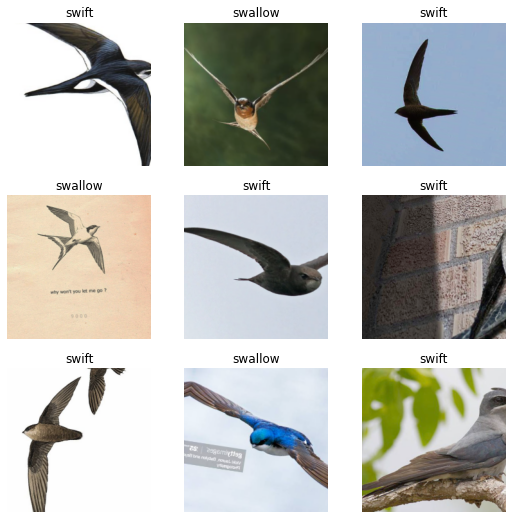

In [ ]:
# Tạo và kiểm tra dữ liệu:
dls = get_dls()
dls.show_batch(max_n=9, ncols=3)

# Base Model

Chúng ta sẽ tạo base model trước khi bắt đầu các bước biến đổi dữ liệu khác nhau để cải thiện model. Chúng ta sẽ sử dụng xresnet50 đã được pretrained làm base model.

In [ ]:
from fastai.metrics import F1Score

In [ ]:
# Tạo learner,sử dụng resnet50 đã được học:
learn = cnn_learner(dls, resnet50, pretrained=True, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])

SuggestedLRs(valley=0.0004786300996784121)


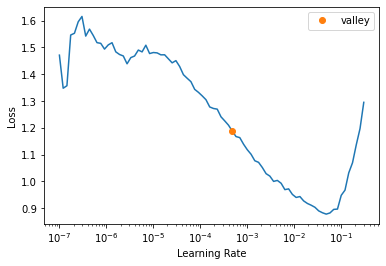

In [ ]:
# Tìm lr tốt nhất để học:
lr_valley = learn.lr_find()
print(lr_valley)

In [ ]:
learn.fit_one_cycle(10, lr_max=lr_valley)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.156006,0.329067,0.866197,0.863309,00:09
1,0.803507,0.288795,0.922535,0.923077,00:08
2,0.626973,0.266260,0.922535,0.923077,00:09
3,0.466765,0.215606,0.929577,0.930556,00:10
4,0.385579,0.252758,0.929577,0.931507,00:10
5,0.316192,0.195435,0.936620,0.938776,00:09
6,0.257207,0.199533,0.936620,0.938776,00:09
7,0.229537,0.215336,0.929577,0.931507,00:09
8,0.197162,0.217857,0.936620,0.938776,00:09
9,0.181882,0.221940,0.936620,0.938776,00:10


__NOTE:__
Chúng ta có thể để ý thấy là kết quả các metrices trong model ở đây có nhỉnh hơn đôi chút so với kết quả trong notebook fastai_framework. Chúng ta coi đây là kết quả để cải thiện dần.

In [ ]:
# Lưu model:
learn.save(f"{save_path}base_model")

Path('/mnt/d/practice/projects/swift_swallow/models/base_model.pth')

In [ ]:
# Xuất model:
learn.export(f"{save_path}/base_model.pkl")

# Sửa đổi dữ liệu
> Chúng ta sẽ đi qua từng phương pháp sửa đổi dữ liệu (Augmentation) như đã liệt kê ở trên

## Progressive Resize

> Progressive resize (tăng kích cỡ ảnh dần dần) là phương pháp được sử dụng trong DL cho hình ảnh khá phổ biến, trong đó, ảnh sẽ được tăng kích cỡ (size) theo nhiều lần train. Với size ảnh nhỏ, model sẽ học nhanh hơn, còn size lớn hơn, model sẽ được chính xác hơn.

Chúng ta sẽ áp dụng chiến thuật này với 3 kích cỡ khác nhau: 128, 224, 256.

### Size = 128

In [ ]:
## Bắt đầu vs 128:
dls = get_dls(128, 128) # bs=128, size=128
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])

SuggestedLRs(valley=0.0003981071640737355)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.166880,0.785112,0.718310,0.701493,00:08
1,0.903364,0.593953,0.852113,0.860927,00:07
2,0.729745,0.487257,0.880282,0.891720,00:08
3,0.627705,0.444625,0.873239,0.886076,00:09
4,0.565739,0.397504,0.873239,0.887500,00:10


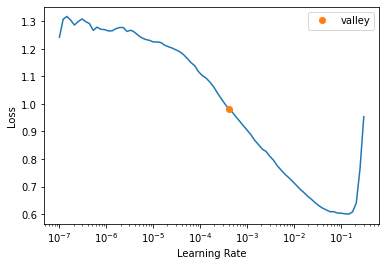

In [ ]:
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(5, lr_max=lr_valley)

__NOTE:__
chúng ta có thể thấy vói size=128, kết quả trả về cho accuracy và F1score thấp hơn so với size=224 của base model ở trên. Chúng ta sẽ tiếp tục thử nghiệm với size lớn hơn.

### Size = 224

SuggestedLRs(valley=0.0008317637839354575)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.400311,0.347411,0.859155,0.863014,00:10
1,0.361367,0.346628,0.908451,0.915033,00:09
2,0.307579,0.340515,0.901408,0.910256,00:10
3,0.258090,0.380616,0.901408,0.907895,00:10
4,0.229510,0.356310,0.936620,0.942675,00:10
5,0.199988,0.324458,0.922535,0.929032,00:10
6,0.173068,0.265950,0.922535,0.927152,00:10
7,0.150360,0.255941,0.922535,0.927152,00:09
8,0.132034,0.251347,0.936620,0.941176,00:09
9,0.120036,0.250680,0.929577,0.934211,00:09


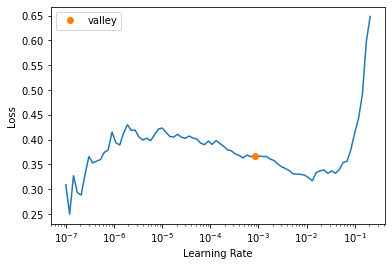

In [ ]:
## Update size của dữ liệu
learn.dls = get_dls(64, 224) # bs=64, size=224
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(10, lr_max=lr_valley)

__NOTE:__ 
Trong quá trình train, chúng ta lưu ý tránh để lỗi typo trong code, có thể ảnh hưởng đến kết quả train! Vì kết quả của chúng ta là dạng lũy kế nên các lỗi sai không đáng có (lr_find, fit_one_cycle) có thể ảnh hưởng đến weights của model.

### Size = 256

SuggestedLRs(valley=0.0003311311302240938)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.173033,0.081924,0.985915,0.987013,00:12
1,0.175393,0.079763,0.985915,0.987013,00:10
2,0.152463,0.050310,0.985915,0.987013,00:10
3,0.122573,0.094004,0.971831,0.974359,00:12
4,0.115107,0.070298,0.978873,0.980645,00:11
5,0.102972,0.075559,0.978873,0.980645,00:10
6,0.098410,0.076752,0.971831,0.974359,00:11
7,0.098164,0.126732,0.957747,0.961039,00:11
8,0.094019,0.130478,0.964789,0.967742,00:11
9,0.086699,0.118737,0.957747,0.961538,00:11


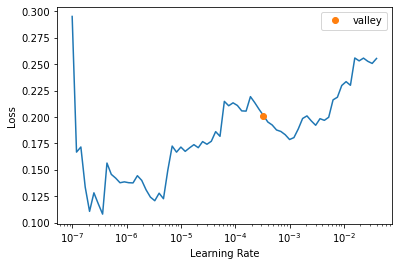

In [ ]:
## Update size của dữ liệu
learn.dls = get_dls(32, 256) # bs=32, size=256
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(15, lr_max=lr_valley)

In [ ]:
# Save:
learn.save(f"{save_path}/model_PR1")

Path('/mnt/d/practice/projects/swift_swallow/models/model_PR1.pth')

In [ ]:
# Export:
learn.export(f"{save_path}/model_PR1.pkl")

__NOTE:__

Bạn có thể thấy, khi tăng size ảnh, tôi cũng giảm số lượng ảnh trong 1 batch, để đảm bảo dữ liệu không lớn quá, khiến GPU bị out of memory.

Với size nhỏ, tôi sử dụng số lượng epoch ít hơn so vs size lớn hơn. Tôi sẽ thử lại với số lượng epoch: 4, 8, 12 cho các lượt xem sao. Bạn cũng có thể thấy, với model đã trược train đi train lại, lr cũng nhỏ đi theo thời gian, do loss đã được cải thiện hơn.

SuggestedLRs(valley=0.0006918309954926372)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.235319,1.324595,0.669014,0.598291,00:10
1,0.922232,0.550758,0.859155,0.866667,00:08
2,0.770427,0.395851,0.866197,0.875817,00:08
3,0.654663,0.363069,0.880282,0.888889,00:08


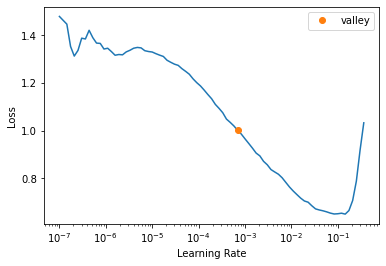

In [ ]:
dls = get_dls(128, 128)
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score()])
lr_valley = learn.lr_find()
print(lr_valley)
learn.fit_one_cycle(4, lr_max=lr_valley)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.403376,0.183419,0.936620,0.941176,00:09
1,0.319821,0.341778,0.901408,0.911392,00:09
2,0.302181,0.220589,0.922535,0.929936,00:08
3,0.296819,0.190675,0.936620,0.943396,00:09
4,0.249705,0.191527,0.943662,0.948052,00:08
5,0.224747,0.201719,0.950704,0.954248,00:09
6,0.200345,0.184146,0.943662,0.947368,00:09
7,0.172840,0.184149,0.936620,0.941176,00:09


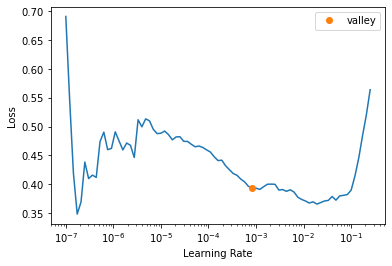

In [ ]:
learn.dls = get_dls(64, 224)
lr_valley = learn.lr_find()
learn.fit_one_cycle(8, lr_max=lr_valley)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.174913,0.035698,0.985915,0.987013,00:10
1,0.206336,0.025772,0.985915,0.987013,00:10
2,0.172206,0.036121,0.978873,0.980645,00:10
3,0.140405,0.028920,0.985915,0.987013,00:11
4,0.131647,0.026586,0.985915,0.987013,00:10
5,0.124669,0.024033,0.985915,0.987013,00:10
6,0.107482,0.013355,0.992958,0.993464,00:10
7,0.099745,0.013841,0.992958,0.993464,00:10
8,0.100015,0.016189,0.992958,0.993464,00:11
9,0.091608,0.016734,0.992958,0.993464,00:10


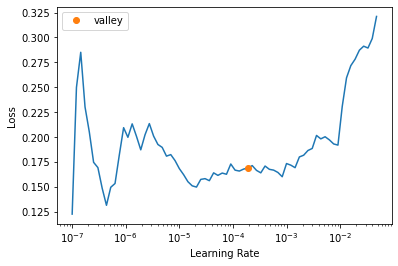

In [ ]:
learn.dls = get_dls(32, 256)
lr_valley = learn.lr_find()
learn.fit_one_cycle(12, lr_max=lr_valley)

__NOTE:__
bạn thấy đó, kết quả thật sự tuyệt vời! Tuy nhiên, chúng ta đã có thể đạt kết quả tốt hơn chỉ với 5 epochs cho size lớn này.
Chúng ta hay lưu lại kết quả này:

In [ ]:
# Save:
learn.save(f"{save_path}/model_PR2")

Path('/mnt/d/practice/projects/swift_swallow/models/model_PR2.pth')

In [ ]:
# Export:
learn.export(f"{save_path}/model_PR2.pkl")

## Test Time Augmentation (TTA)

> Phương pháp TTA là sử dụng augmentation vào dữ liệu test để dự đoán mô hình, sau đó với tất cả các dự đoán này, chúng ta sẽ đưa ra dự đoán trung bình. 

In [ ]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

1.0

Chỉ đơn giản vậy mà chúng ta có thể thấy kết quả thực sự vượt trội!

## MixUp

> MixUp cũng là một trong nhưng phương pháp sửa ảnh khá thú vị mà chúng ta có thể sử dụng. Ý tưởng của phương pháp này là chúng ta sẽ tạo ra thêm các bức ảnh là sự kết hợp giữa 2 ảnh bất kỳ nào đó với 1 tỷ lệ nhất định, ví dụ 70% chim Yến, 30% chim Yén. Việc này cũng sẽ khiến cho khả năng dự đoán của model sẽ khó hơn. Ngoài ra, kết quả dự đoán cuối cùng sẽ không phải là chim Yến (70%) mà phải là 70% chim Yến, 30% chim Yén. 

Chúng ta hay cùng đi qua ví dụ để hiểu nó hơn:

In [ ]:
from fastai.callback import mixup
mixup_ = mixup.MixUp(alpha=0.3)

In [ ]:
dls = get_dls(32, 224)
model = xresnet50()
model1 = resnet50(pretrained=True)

SuggestedLRs(valley=0.0008317637839354575)


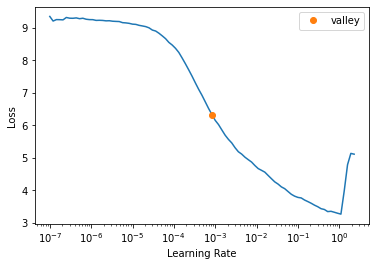

In [ ]:
learn = Learner(dls, model1, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, F1Score(average='macro')])
lr_valley = learn.lr_find()
print(lr_valley)

In [ ]:
learn.fit_one_cycle(80, lr_max=lr_valley, cbs=[mixup_])

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,7.304945,3.140878,0.528169,0.024797,00:11
1,5.311904,1.902224,0.753521,0.099134,00:11
2,3.777653,0.979932,0.873239,0.871995,00:11
3,2.676127,0.587420,0.908451,0.902529,00:11
4,1.934577,0.340343,0.901408,0.899413,00:11
5,1.447083,0.351313,0.908451,0.903869,00:11
6,1.108556,0.325162,0.887324,0.881296,00:11
7,0.845221,0.383322,0.866197,0.864687,00:11
8,0.686532,0.418802,0.802817,0.802189,00:11
9,0.560684,0.256828,0.922535,0.918659,00:11


In [ ]:
# Save:
learn.save(f"{save_path}model_mixup")

Path('/mnt/d/practice/projects/swift_swallow/models/model_mixup.pth')

In [ ]:
# Export:
learn.export(f"{save_path}model_mixup.pkl")

Chúng ta có thể thấy, càng train, kết quả càng tiến bộ hơn. Ở đây chúng ta mới chỉ sử dụng 80 epochs để chạy thử mixup. Tuy nhiên, kết quả cuối cũng cũng đã rất tốt rồi. Nếu tiếp tục > 80 epochs, tôi tin kết quả có thể còn tốt hơn nữa.

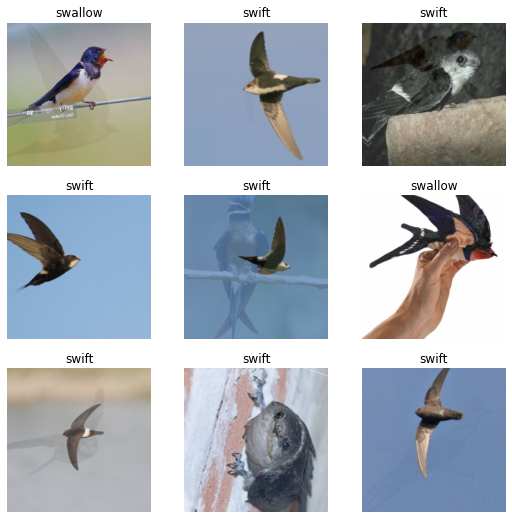

In [ ]:
# Trực quan hóa dữ liệu khi sử dụng mixup:
mixup_ = mixup.MixUp(.3)
with Learner(dls, nn.Linear(3, 4), loss_func=CrossEntropyLossFlat(), cbs=mixup_) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup_.x,mixup_.y), ctxs=axs.flatten())

**Lưu ý:**
Theo thông số trên bảng [Leaderboard](https://github.com/fastai/imagenette) của fastai, mixup có kết quả tốt với số lượng epoch > 80.

## Label Smooth
> Label smooth có sự tương đồng với MixUp. Chúng ta tạo ra dữ liệu được sửa đổi thông qua việc gộp các ảnh với nhau như cách làm của mixup, hoặc có thể sửa label với bằng giá trị tương đối từ 0-1 thay vì chỉ có thể là 0 hoặc 1. Việc này sẽ giúp cho model học tốt hơn thay vì phải cố gắng để học đúng được giá trị tuyệt đối là 1. c

In [ ]:
dls = get_dls(32, 224)
model = xresnet50()
model1 = resnet50(pretrained=True)

SuggestedLRs(valley=0.0010000000474974513)


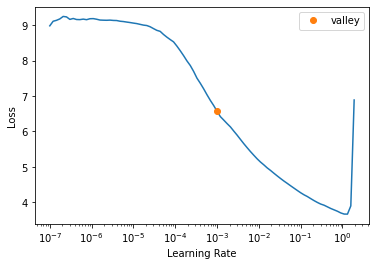

In [ ]:
learn = Learner(dls, model1, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy, F1Score(average='macro')])
lr_valley = learn.lr_find()
print(lr_valley)

In [ ]:
learn.fit_one_cycle(20, lr_max=lr_valley)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,6.569699,2.327586,0.830986,0.212407,00:11
1,3.947835,2.368878,0.866197,0.574080,00:11
2,2.853073,1.852815,0.746479,0.505850,00:11
3,2.255528,1.348753,0.901408,0.899413,00:11
4,1.893813,1.544590,0.852113,0.851929,00:11
5,1.659043,1.424473,0.887324,0.886762,00:11
6,1.490016,1.269464,0.908451,0.907119,00:11
7,1.386474,1.477328,0.887324,0.881296,00:10
8,1.307406,1.345478,0.894366,0.893473,00:11
9,1.254568,1.199837,0.943662,0.941383,00:11


In [ ]:
# Save
learn.save(f"{save_path}model_ls")

Path('/mnt/d/practice/projects/swift_swallow/models/model_ls.pth')

In [ ]:
# Export:
learn.export(f"{save_path}model_ls.pkl")